# Profit Allocation in Federated Learning | A Playground

*This notebook was developed for the project **"MSAI/21/017 - IMPLEMENTING A GENERAL FRAMEWORK FOR PARTICIPANT’S CONTRIBUTION CALCULATION IN FEDERATED LEARNING"**. The aim of the project is to develop a system that will test the effectiveness of profit allocation using Shapley Value in Horizontal Federated Learning systems.*

The system has the following customizable functions:

1. Dataset
    - MNIST
    - EMNIST
2. Neural Network Model Size
    - Small MLP
    - Medium MLP
    - Large MLP
3. Contribution Metrics / Reward Function
    - Loss
    - Accuracy
    - F1
4. Individual Client Behaviour
    - Normal
    - Free-rider (No training done)
    - Adversarial (Randomize weights + bias)
5. Client Dataset Distribution (IID)
    - IID
    - Non-IID 1 (Overlapping sample sets)
    - Non-IID 2 (Unequal data distribution)
    - Non-IID 1+2

Once the program completes, it will output the following data:

1. Client-server loss and accuracy over epochs
2. Rewards distribution over time
3. Client-server training timings

## Import libraries

In [ ]:
#!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

In [ ]:
# Verify assigned Google Collab GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 19 05:55:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |   1153MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline

# Load libraries
import math, random, copy, os, glob, time
from itertools import chain, combinations, permutations
from pprint import pprint

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import datasets, transforms as T

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Standardize randomness
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Define system hyper-parameters [ EDIT HERE ]

In [ ]:
## USER DEFINED EXPERIMENT PARAMETERS

# Federated network settings
MODEL_SIZE = 'MEDIUM'            # SMALL / MEDIUM / LARGE
REWARD_METRICS = ['LOSS']       # LOSS / ACCURACY / F1 - Metrics sum to select best model for each communication round
COMM_ROUNDS = 15                 # Number of communication rounds between server and clients
SHAPLEY_FILTER = False           # True / False - If true, select only the best coalition model per communication round
COALITION_LIMIT = 0            # Limits the size of individual coalitions (Set as non-positive number to disable limit)

# Training dataset settings
DATASET_TYPE = 'MNIST'      # MNIST / EMNIST
DISTRIBUTION_TYPE = 'IID'   # IID / NIID_1 / NIID_2 / NIID_12
BATCH_SIZE = 64             # Dataset batch size

# Training hyper-parameters and functions for the Federated modeel
INIT_LEARN_RATE = 0.1
LOSS_FUNC = nn.CrossEntropyLoss
OPTIMIZER = torch.optim.SGD
MOMENTUM = .9
WEIGHT_DECAY = 1e-5
EPOCHS = 10                  # Number of epochs each client will train over

# Client behaviours each parameter represents the number of clients running in the network
NUM_NORMAL_CLIENTS = 4          # Client trains model and returns updated parameters
NUM_FREERIDER_CLIENTS = 0       # Client does not train model and returns original parameters
NUM_ADVERSARIAL_CLIENTS = 1     # Client returns randomized parameters 

## Initialize system and define helper functions

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Create subdirectories
model_path = './models'

def createDirectory(path):
    pathExists = os.path.exists(path)
    if not pathExists:
        print(f'"{path}" does not exist.')
        os.makedirs(path)
        print(f'"{path}" created.')
        
createDirectory(model_path)

# Delete existing .pt files from previous run
def deleteAllModels(path):
    filepaths = glob.glob(f'{path}/**/*.pt', recursive=True)
    for filepath in filepaths:
        os.remove(filepath)
        print(f'"{filepath}" deleted.')
        
deleteAllModels(model_path)

# Complete
print('\nLibraries and directories initialized.')

Using cuda device
"./models/FedAvg/server/server_model.pt" deleted.
"./models/FedAvg/client/client_2.pt" deleted.
"./models/FedAvg/client/client_4.pt" deleted.
"./models/FedAvg/client/client_1.pt" deleted.
"./models/FedAvg/client/client_0.pt" deleted.
"./models/FedAvg/client/client_3.pt" deleted.
"./models/ShapleyValue-CL3/server/server_model.pt" deleted.
"./models/ShapleyValue-CL3/client/client_2.pt" deleted.
"./models/ShapleyValue-CL3/client/client_4.pt" deleted.
"./models/ShapleyValue-CL3/client/client_1.pt" deleted.
"./models/ShapleyValue-CL3/client/client_0.pt" deleted.
"./models/ShapleyValue-CL3/client/client_3.pt" deleted.
"./models/ShapleyValue-CL2/server/server_model.pt" deleted.
"./models/ShapleyValue-CL2/client/client_2.pt" deleted.
"./models/ShapleyValue-CL2/client/client_4.pt" deleted.
"./models/ShapleyValue-CL2/client/client_1.pt" deleted.
"./models/ShapleyValue-CL2/client/client_0.pt" deleted.
"./models/ShapleyValue-CL2/client/client_3.pt" deleted.
"./models/ShapleyValue

In [ ]:
# Helper functions

# Recipe modified from Python itertools documentation: 
# https://docs.python.org/3/library/itertools.html#itertools-recipes
def powerset(iterable, no_null = True):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1 if no_null else 0, len(s)+1))

def aggListOfDicts(lst):
    '''
        Combines a list of dictionaries into a dictionary of lists
    '''
    agg = {}
    for dct in lst:
        for name, val in dct.items():
            if name in agg:
                agg[name] += [val]
            else:
                agg[name] = [val]

    return agg

## Setup train and test datasets and dataloaders

In [ ]:
# Download training and test data from open datasets

''' transforms = T.Compose([
    #T.RandomHorizontalFlip(),
    #T.RandomVerticalFlip(),
    #T.RandomRotation(degrees=(0, 180)),
    T.ToTensor(),
    T.Normalize((0.5), (0.5)),
]) '''

# MLP model uses Fashion-MNIST
if DATASET_TYPE == 'MNIST':
  train_data = datasets.MNIST(
      root="data",
      train=True,
      download=True,
      transform=T.ToTensor(),
  )

  test_data = datasets.MNIST(
      root="data",
      train=False,
      download=True,
      transform=T.ToTensor(),
  )

  CLASS_SIZE = 10

elif DATASET_TYPE == 'EMNIST':
  train_data = datasets.EMNIST(
      root="data",
      train=True,
      download=True,
      split='balanced',
      transform=T.ToTensor(),
  )

  test_data = datasets.EMNIST(
      root="data",
      train=False,
      download=True,
      split='balanced',
      transform=T.ToTensor(),
  )

  CLASS_SIZE = 47

print(f'{DATASET_TYPE} training dataset has {len(train_data)} samples.')
print(f'{DATASET_TYPE} test dataset has {len(test_data)} samples.')

MNIST training dataset has 60000 samples.
MNIST test dataset has 10000 samples.


Training dataset samples:


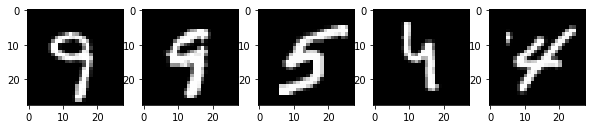

Test dataset samples:


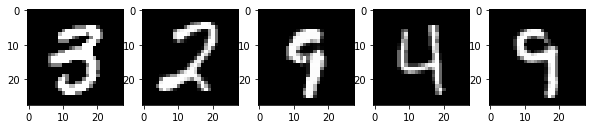

In [ ]:
# Visualize selected dataset, sanity check purpose

def showImageSamples(dataset,cols=5,rows=1):
    figure = plt.figure(figsize=(10, 10))
    cols, rows = 5, 1
    for i in range(cols*rows):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i+1)
        # plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

print('Training dataset samples:')
showImageSamples(train_data)

print('Test dataset samples:')
showImageSamples(test_data)

In [ ]:
# Functions to split dataset based on IID or Non-IID selection

def prepareIID(dataset, num_clients):
    '''
        Prepares IID training datasets for each client
    '''
    dataset_split = [[] for i in range(num_clients)]
    
    for idx, sample in enumerate(dataset):
        dataset_split[idx%num_clients] += [sample]
    
    return dataset_split
    
def prepareNIID1(dataset, num_clients):
    '''
        Prepares NIID-1 training datasets for each client (Overlapping sample sets)
    '''
    dataset_split = [[] for i in range(num_clients)]
            
    for idx, sample in enumerate(dataset):
        dataset_split[idx%num_clients] += [random.choice(dataset)]
    
    return dataset_split

def prepareNIID2(dataset, num_clients):
    '''
        Prepares NIID-1 training datasets for each client (Unequal data distribution)
    '''
    dataset_split = [[] for i in range(num_clients)]
    
    for idx, sample in enumerate(dataset):
        dataset_split[random.randint(0,num_clients-1)] += [sample]
    
    return dataset_split

def prepareNIID12(dataset, num_clients):
    '''
        Prepares NIID-1+2 training datasets for each client 
        (Overlapping sample sets + Unequal data distribution)
    '''
    dataset_split = [[] for i in range(num_clients)]
    
    for sample in dataset:
        dataset_split[random.randint(0,num_clients-1)] += [random.choice(dataset)]
    
    return dataset_split

In [ ]:
# Split training dataset for clients
NUM_OF_CLIENTS = NUM_NORMAL_CLIENTS + NUM_FREERIDER_CLIENTS + NUM_ADVERSARIAL_CLIENTS
if DISTRIBUTION_TYPE == 'IID':
    train_datasets = prepareIID(train_data, NUM_OF_CLIENTS)
elif DISTRIBUTION_TYPE == 'NIID_1':
    train_datasets = prepareNIID1(train_data, NUM_OF_CLIENTS)
elif DISTRIBUTION_TYPE == 'NIID_2':
    train_datasets = prepareNIID2(train_data, NUM_OF_CLIENTS)
elif DISTRIBUTION_TYPE == 'NIID_12':
    train_datasets = prepareNIID12(train_data, NUM_OF_CLIENTS)

train_dataloaders = [DataLoader(train_dataset, batch_size=BATCH_SIZE) for train_dataset in train_datasets]

# Sanity check a training dataloader
for X, y in train_dataloaders[0]:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
# Create test dataloader.
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE*2)

# Sanity check test dataloader
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


## Define neural nework models

In [ ]:
# Define models

class SmallMLP(nn.Module):
    '''
        Multi-Layer Perceptron
    '''
    def __init__(self):
        super(SmallMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, CLASS_SIZE)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class MediumMLP(nn.Module):
    '''
        Multi-Layer Perceptron
    '''
    def __init__(self):
        super(MediumMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, CLASS_SIZE)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class LargeMLP(nn.Module):
    '''
        Multi-Layer Perceptron
    '''
    def __init__(self):
        super(LargeMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, CLASS_SIZE)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Define checkpoint functions (Simulates data exchange between clients and server)
    
def saveCheckpoint(name, model_state_dict, optimizer_state_dict, filepath, verbose=False):
    '''
        Saves state dictionaries of model and optimizer as a .pt file
    '''
    torch.save({
        'name': name,
        'model_state_dict': model_state_dict,
        'optimizer_state_dict': optimizer_state_dict,
    }, filepath)
    
    if verbose:
        print(f'\n"{name}" model saved as "{filepath}".\n')
        
    return True
    
def loadCheckpoint(filepath, verbose=False):
    '''
        Loads and returns the state dictionaries of model and optimizer from a .pt file
    '''
    checkpoint = torch.load(filepath)
    
    if verbose:
        name = checkpoint['name']
        print(f'\n"{name}" model loaded from "{filepath}".\n')
    
    return checkpoint

def print_parameters(model):
    '''
        Outputs the learnable parameter counts for each layer and in total
    '''
    print('Model Layer Parameters:\n')
    total_params = 0
    for name, parameter in model.named_parameters():
            if not parameter.requires_grad:
                continue
            params = parameter.numel()
            print(f'{name} - {params} parameters')
            total_params += params
    print(f'\n>>Total - {total_params} parameters\n')

## Initialize Federated Model and hyper-parameters

In [ ]:
# Define network model architecture
FederatedModel = None

if MODEL_SIZE == 'SMALL':
    FederatedModel = SmallMLP
elif MODEL_SIZE == 'MEDIUM':
    FederatedModel = MediumMLP
elif MODEL_SIZE == 'LARGE':
    FederatedModel = LargeMLP
    
print_parameters(FederatedModel())

# Define network training functions and hyper-parameters
FederatedLossFunc = LOSS_FUNC
FederatedOptimizer = OPTIMIZER
FederatedLearnRate = INIT_LEARN_RATE
FederatedMomentum = MOMENTUM
FederatedWeightDecay = WEIGHT_DECAY

Model Layer Parameters:

linear_relu_stack.0.weight - 401408 parameters
linear_relu_stack.0.bias - 512 parameters
linear_relu_stack.2.weight - 262144 parameters
linear_relu_stack.2.bias - 512 parameters
linear_relu_stack.4.weight - 262144 parameters
linear_relu_stack.4.bias - 512 parameters
linear_relu_stack.6.weight - 5120 parameters
linear_relu_stack.6.bias - 10 parameters

>>Total - 932362 parameters



## Server functions

In [ ]:
def initServer(model_path,folder_name,dataloader):
    '''
        Initializes server model and returns object with attributes
    '''
    print('Initializing server model...')
    # Spawn server model and functions
    server_name = 'server'
    server_model = FederatedModel().to(device)
    server_loss_func = FederatedLossFunc()
    server_optimizer = FederatedOptimizer(server_model.parameters(), lr=FederatedLearnRate, momentum=FederatedMomentum, weight_decay=FederatedWeightDecay)
    server_dataloader = dataloader

    print(server_model,'\n')
    print(server_optimizer)

    createDirectory(f'{model_path}/{folder_name}/server')
    createDirectory(f'{model_path}/{folder_name}/client')

    # Collect objects into a reference dictionary
    server = {
        'name': server_name,
        'model': server_model,
        'dataloader': server_dataloader,
        'optimizer': server_optimizer,
        'loss_func': server_loss_func,
        'filepath': f'{model_path}/{folder_name}/server/server_model.pt',
        'client_filepath': f'{model_path}/{folder_name}/client'
    }

    # Save server model state_dicts (simulating public access to server model parameters)
    saveCheckpoint(
        server_name,
        server_model.state_dict(),
        server_optimizer.state_dict(),
        server['filepath'],
        verbose=True
    )

    return server

## Clients functions

In [ ]:
def initClients(num_norm,num_free,num_avsl,server,dataloaders):
  '''
      Initializes clients objects and returns a list of client object
  '''

  print('Initializing clients...')
  # Setup client devices
  behaviour_list = [
      *['NORMAL' for i in range(num_norm)],
      *['FREERIDER' for i in range(num_free)],
      *['ADVERSARIAL' for i in range(num_avsl)],
  ]

  clients = []
  for n, behaviour in enumerate(behaviour_list):     
      # Spawn client model and functions
      client_name = f'client_{n}'
      
      # Collect client's objects into a reference dictionary
      clients += [{
          'name': client_name,
          'behaviour': behaviour,
          'filepath': f'{server["client_filepath"]}/{client_name}.pt',
          'dataloader': dataloaders[n]
      }]
      
  print('Client Name / Behaviour:', [(client['name'], client['behaviour']) for client in clients], '\n')

  return clients

## Define train and test functions

In [ ]:
def train(dataloader, model, loss_fn, optimizer, verbose=False):
    '''
        Trains a NN model over a dataloader
    '''
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
            return loss

In [ ]:
def test(dataloader, model, loss_fn, verbose=False):
    '''
        Tests a NN model over a dataloader
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss, correct, f1 = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
            f1 += f1_score(y.cpu(), y_pred.argmax(1).cpu(), average='micro')

    test_loss /= num_batches
    correct /= size
    f1 /= num_batches
    
    if verbose:
        print(f"Test Error: \n Accuracy: {correct:>8f}, Avg loss: {test_loss:>8f}, F1: {f1:>8f} \n")
        
    return test_loss, correct, f1

### Client training functions

In [ ]:
def trainClients(clients, server):
    '''
        Trains a list of client devices and saves their parameters
    '''
    loss, acc, f1 = {}, {}, {}
    for client in clients:
        train_loss, test_loss, test_acc, test_f1 = trainClient(client, server)

        # Aggregate statistics
        loss[client['name']] = test_loss
        acc[client['name']] = test_acc
        f1[client['name']] = test_f1
    
    return loss, acc, f1

def trainClient(client, server):
    '''
        Trains a client device and saves its parameters
    '''
    # Read client behaviour setting
    client_behaviour = client['behaviour']
    
    # Load local dataset
    client_dataloader = client['dataloader']
    
    # Get client model and functions
    client_name = client['name']
    client_model = FederatedModel().to(device)
    client_loss_fn = FederatedLossFunc()
    client_optimizer = FederatedOptimizer(client_model.parameters(), lr=FederatedLearnRate, momentum=FederatedMomentum, weight_decay=FederatedWeightDecay)
    
    # If client is adversarial, they return randomized parameters
    if client_behaviour == 'ADVERSARIAL':
        # Save client model state_dicts (simulating client uploading model parameters to server)
        saveCheckpoint(
            client_name,
            client_model.state_dict(),
            client_optimizer.state_dict(),
            client['filepath'],
        )
        
        test_loss, test_acc, test_f1 = test(server['dataloader'], client_model, client_loss_fn)
        print(f"{client_name} ({client_behaviour}) Test Acc: {test_acc:>8f}, Loss: {test_loss:>8f}, F1: {test_f1:>8f}")
        
        return 0, test_loss, test_acc, test_f1
    
    # Load server model state_dicts (simulating client downloading server model parameters)
    checkpoint = loadCheckpoint(server['filepath'])
    client_model.load_state_dict(checkpoint['model_state_dict']) # Using current server model parameters
    # client_optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Using current server model parameters
    
    # If client is a freeloader, they return the same server model parameters
    if client_behaviour == 'FREERIDER':
        # Save client model state_dicts (simulating client uploading model parameters to server)
        saveCheckpoint(
            client_name,
            client_model.state_dict(),
            client_optimizer.state_dict(),
            client['filepath'],
        )
        
        test_loss, test_acc, test_f1 = test(server['dataloader'], client_model, client_loss_fn)
        print(f"{client_name} ({client_behaviour}) Test Acc: {test_acc:>8f}, Loss: {test_loss:>8f}, F1: {test_f1:>8f}")
        
        return 0, test_loss, test_acc, test_f1
    
    # If client is normal, they train client over N epochs
    epochs = EPOCHS
    print(f'Training {client_name} over {epochs} epochs...')
    for t in range(epochs):
        train_loss = train(client_dataloader, client_model, client_loss_fn, client_optimizer)

    test_loss, test_acc, test_f1 = test(server['dataloader'], client_model, client_loss_fn)
    print(f"{client_name} ({client_behaviour}) Test Acc: {test_acc:>8f}, Loss: {test_loss:>8f}, F1: {test_f1:>8f}")

    # Save client model state_dicts (simulating client uploading model parameters to server)
    saveCheckpoint(
        client_name,
        client_model.state_dict(),
        client_optimizer.state_dict(),
        client['filepath'],
    )

    return train_loss, test_loss, test_acc, test_f1

### FedAvg core function

In [ ]:
def FedAvg(model_state_dicts):
    '''
        Calculates and generates the FedAvg of the state_dict of a list of models. Returns the FedAvg state_dict.
    '''
    # Sum up tensors from all states
    state_dict_sum = {} # Stores the sum of state parameters
    for state_dict in model_state_dicts:
        for key, params in state_dict.items():
            if key in state_dict_sum:
                state_dict_sum[key] += params.detach().clone()
            else:
                state_dict_sum[key] = params.detach().clone()
                
    # Get Federated Average of clients' parameters
    state_dict_avg = {}
    for key in state_dict_sum:
        state_dict_avg[key] = state_dict_sum[key] / len(model_state_dicts)

    return state_dict_avg

### Naive FedAvg server training functions

In [ ]:
def evalFedAvg(server):  
    '''
        Load client state dicts, perform parameter aggregation and evaluate contributions for each client
    '''
    # Retrieve all clients' uploaded data
    client_filepaths = glob.glob(f"{server['client_filepath']}/client*.pt")
    
    # Load client model state_dicts (simulating client downloading server model parameters)
    client_checkpoints = []
    for client_filepath in client_filepaths:
        client_checkpoint = loadCheckpoint(client_filepath)
        client_checkpoints += [client_checkpoint]
                
    # Get Federated Average of clients' parameters
    model_state_dicts = [checkpoint['model_state_dict'] for checkpoint in client_checkpoints]
    fed_model_state_dict = FedAvg(model_state_dicts)

    # Instantiate server model using FedAvg
    fed_model = FederatedModel().to(device)
    fed_model.load_state_dict(fed_model_state_dict)
    fed_model.eval()

    # Evaluate FedAvg server model
    start_time = time.time() # Time evaluation period
    eval_loss, eval_acc, eval_f1 = test(server['dataloader'], fed_model, server['loss_func'])
    time_taken = time.time() - start_time # Get model evaluation period (in seconds)
    print(f"\n>> Federated Model Acc: {eval_acc:>8f}, Loss: {eval_loss:>8f}, F1: {eval_f1:>8f}\n")
    
    # Save server model state_dicts (simulating public access to server model parameters)
    saveCheckpoint(
        server['name'],
        fed_model.state_dict(),
        server['optimizer'],
        server['filepath'],
    )

    # Output statistics
    return eval_loss, eval_acc, eval_f1, time_taken

In [ ]:
def trainFedAvgModel(rounds=5):
    '''
        Train a model using naive FedAvg
    '''
    
    loss, acc, f1, eval_time = [], [], [], []
    for i in range(rounds):
        print(f'\n=======================\n\tROUND {i+1}\n=======================')
        clients_loss, clients_acc, clients_f1 = trainClients(clients, server)
        server_loss, server_acc, server_f1, time_taken = evalFedAvg(server)

        # Compile performance measures 
        loss += [{ **clients_loss, **{'server': server_loss} }]
        acc += [{ **clients_acc, **{'server': server_acc} }]
        f1 += [{ **clients_f1, **{'server': server_f1} }]
        eval_time += [time_taken]

    # Output statistics
    return aggListOfDicts(loss), aggListOfDicts(acc), aggListOfDicts(f1), eval_time

### FedAvg-Shapley server training functions

In [ ]:
def evalFedAvgShapley(server, shapley_filter=True, coalition_limit=0):
    '''
        Evaluates and rewards clients based on marginal contributions in coalition permutations
    '''

    # Evaluate current server model performance
    server_checkpoint = loadCheckpoint(server['filepath'])
    server_model = FederatedModel().to(device)
    server_model.load_state_dict(server_checkpoint['model_state_dict'])
    
    # Evaluate server model
    server_loss, server_acc, server_f1 = test(server['dataloader'], server_model, server['loss_func'])

    print(f"\n>> Current Server Model Acc: {server_acc:>8f}, Loss: {server_loss:>8f}, F1: {server_f1:>8f}\n")

    # Coalition Limit only valid if Shapley Filter is True
    if not shapley_filter:
        coalition_limit = 0
        
    # Load client model state_dicts (simulating server sideloading client model parameters)
    client_filepaths = glob.glob(f"{server['client_filepath']}/client*.pt")

    client_checkpoints = {}
    for client_filepath in client_filepaths:
        client_checkpoint = loadCheckpoint(client_filepath)
        client_checkpoints[client_checkpoint['name']] = client_checkpoint
    client_names = [client_id for client_id in client_checkpoints]

    # We generate non-null powerset of selected clients
    coalitions = list([frozenset(subset) for subset in powerset(client_names)])

    # We prune number of coalitions based on Coalition Limit parameter
    if coalition_limit > 0:
        limited_coalitions = []
        for coalition in coalitions:
            if len(coalition) <= coalition_limit:
                limited_coalitions += [coalition]
        coalitions = limited_coalitions

    # We generate order permutations of selected clients
    orders = list(permutations(client_names))

    # We prune length of coalitions based on Coalition Limit parameter
    if coalition_limit > 0:
        orders = list(set([order[:coalition_limit] for order in orders]))

    # We calculate the contributions of each coalition
    print('FedAvg Coalition Evaluations:')

    best_model_state_dict, best_name = server_checkpoint['model_state_dict'], 'server' # We keep track of the best performing model
    best_loss, best_acc, best_f1, best_utility = server_loss, server_acc, server_f1, 0.0
    utilities = {}

    fed_model = FederatedModel().to(device)

    time_taken = 0 # Get model evaluation period (in seconds)
    for coalition in coalitions:
        # Keep track of largest coalition
        is_largest_coalition = False
        if len(coalition) == len(client_names):
            is_largest_coalition = True

        coalition_names = [client_id for client_id in coalition]
                    
        # Get Federated Average of clients' parameters
        model_state_dicts = [client_checkpoints[client_id]['model_state_dict'] for client_id in coalition_names]
        fed_model_state_dict = FedAvg(model_state_dicts)

        # Instantiate server model using FedAvg
        fed_model.load_state_dict(fed_model_state_dict)
        fed_model.eval()
        
        # Evaluate FedAvg server model
        start_time = time.time() # Time evaluation period
        eval_loss, eval_acc, eval_f1 = test(server['dataloader'], fed_model, FederatedLossFunc())
        time_taken += time.time() - start_time # Accumulate model evaluation period (in seconds)

        print(f">> {'-'.join(coalition_names)} Acc: {eval_acc:>8f}, Loss: {eval_loss:>8f}, F1: {eval_f1:>8f}")
        
        # Evaluate marginal contributions (Coalition model metrics - Server model metrics) > 0
        utility_loss = max(0, server_loss - eval_loss) # Reversed because lower loss == better performance
        utility_acc = max(0, eval_acc - server_acc)
        utility_f1 = max(0, eval_f1 - server_f1)
        
        utility_sum = 0
        for metric in REWARD_METRICS:
            if metric == 'LOSS': utility_sum += utility_loss
            elif metric == 'ACC': utility_sum += utility_acc
            elif metric == 'F1': utility_sum += utility_f1
        
        # Using Shapley Filter, keep the best model and statistics 
        if shapley_filter:
            if utility_sum > best_utility:
                best_name = '-'.join(coalition_names)
                best_model_state_dict = fed_model_state_dict
                best_utility = utility_sum
                best_loss, best_acc, best_f1 = eval_loss, eval_acc, eval_f1
        # Otherwise, the largest coalition is the best model
        else:
            if is_largest_coalition:
                best_name = '-'.join(coalition_names)
                best_model_state_dict = fed_model_state_dict
                best_utility = utility_sum
                best_loss, best_acc, best_f1 = eval_loss, eval_acc, eval_f1
        
        utilities[coalition] = {
            'loss': utility_loss,
            'acc': utility_acc,
            'f1': utility_f1,
            'sum': utility_sum
        }

    print(f'\nFedAvg Coalition Contributions:')
    for coalition in utilities:
        coalition_names = [client_id for client_id in coalition]
        print(f">> '{'-'.join(coalition_names)}' Acc: {utilities[coalition]['acc']:>8f}, Loss: {utilities[coalition]['loss']:>8f}, F1: {utilities[coalition]['f1']:>8f}, Sum: {utilities[coalition]['sum']:>8f}")

    # Save server model state_dicts (simulating public access to server model parameters)
    print(f'\nBest Coalition: {best_name}. Utility Sum: {best_utility:>8f}. Saving Coalition Model as Server Model.')
    saveCheckpoint(
        server['name'],
        best_model_state_dict,
        server['optimizer'],
        server['filepath'],
    )

    # We calculate the contributions of each client in order using utility
    contributions = {}
    for order in orders:
        index = 1
        prev_suborder = []
        
        # Calculate contribution of each client in this order
        for client_id in order:
            cur_suborder = order[:index] # eg. ['A'] -> ['A','B'] -> ['A','B','C']
            
            # If index > 1, we deduct this suborder's utility from prev suborder (eg. u(AB) - u(A) = c(B))
            if index > 1:
                cur_utilities = utilities[frozenset(cur_suborder)]
                prev_utilities = utilities[frozenset(prev_suborder)]
                
                ans = {}
                for utility_metric in cur_utilities:
                    ans[utility_metric] = max(0,cur_utilities[utility_metric] - prev_utilities[utility_metric])
                
            # If index == 1, this is a single element's contribution (eg. u(A) = c(A))
            else:
                ans = utilities[frozenset([client_id])]

            # Add value to client's list of contributions
            if not client_id in contributions:
                    contributions[client_id] = {}
            
            for utility_metric in ans:                
                if utility_metric in contributions[client_id]:
                    contributions[client_id][utility_metric] += [ans[utility_metric]]
                else:
                    contributions[client_id][utility_metric] = [ans[utility_metric]]

            index += 1
            prev_suborder += [client_id]

    # We calculate the Shapley Value of each client by averaging the sum of their contributions
    print(f'\nClient Shapley Values:')
    for client_id in contributions:
        txt = f'>> {client_id}:'
        for metric in contributions[client_id]:
            metric_values = contributions[client_id][metric]
            contributions[client_id][metric] = sum(metric_values) / len(metric_values)
            txt += f' {metric}: {contributions[client_id][metric]:>8f},'
        print(txt)

    # Output statistics
    return best_loss, best_acc, best_f1, time_taken, best_name, {name:vals['sum'] for name, vals in contributions.items()}

In [ ]:
def trainFedAvgShapleyModel(rounds=5, shapley_filter=True, coalition_limit=0):
    '''
        Train a model using FedAvg using Shapley Value
    '''

    loss, acc, f1, eval_time, best_coalitions, sv = [], [], [], [], [], []
    for i in range(rounds):
        print(f'\n=======================\n\tROUND {i+1}\n=======================')
        clients_loss, clients_acc, clients_f1 = trainClients(clients, server)
        server_loss, server_acc, server_f1, time_taken, best_coalition, clients_sv = evalFedAvgShapley(server, shapley_filter, coalition_limit)

        # Compile performance measures 
        loss += [{ **clients_loss, **{'server': server_loss} }]
        acc += [{ **clients_acc, **{'server': server_acc} }]
        f1 += [{ **clients_f1, **{'server': server_f1} }]
        eval_time += [time_taken]
        best_coalitions += [best_coalition]   # Name of best coalition (string)
        sv += [clients_sv]              # Shapley Values of every client

    # Output statistics
    return aggListOfDicts(loss), aggListOfDicts(acc), aggListOfDicts(f1), eval_time, best_coalitions, aggListOfDicts(sv)

## Train a Naive FedAvg model

In [ ]:
# Initalize server and clients
server = initServer(model_path,'FedAvg',test_dataloader)
clients = initClients(NUM_NORMAL_CLIENTS,NUM_FREERIDER_CLIENTS,NUM_ADVERSARIAL_CLIENTS,server,train_dataloaders)

# Train and evaluate
fedavg_loss, fedavg_acc, fedavg_f1, fedavg_time = trainFedAvgModel(COMM_ROUNDS)

Initializing server model...
MediumMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
) 

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

"server" model saved as "./models/FedAvg/server/server_model.pt".

Initializing clients...
Client Name / Behaviour: [('client_0', 'NORMAL'), ('client_1', 'NORMAL'), ('client_2', 'NORMAL'), ('client_3', 'NORMAL'), ('client_4', 'ADVERSARIAL')] 


	ROUND 1
Training client_0 over 10 epochs...
client_0 (NORMAL) Test Acc: 0.124300, Loss: 2.291057, F1: 0.124308
Training client_1 over 10 epochs...
client_1 (NORMAL) Test Acc: 0.181100, Loss: 2.333942, F1: 0.18117

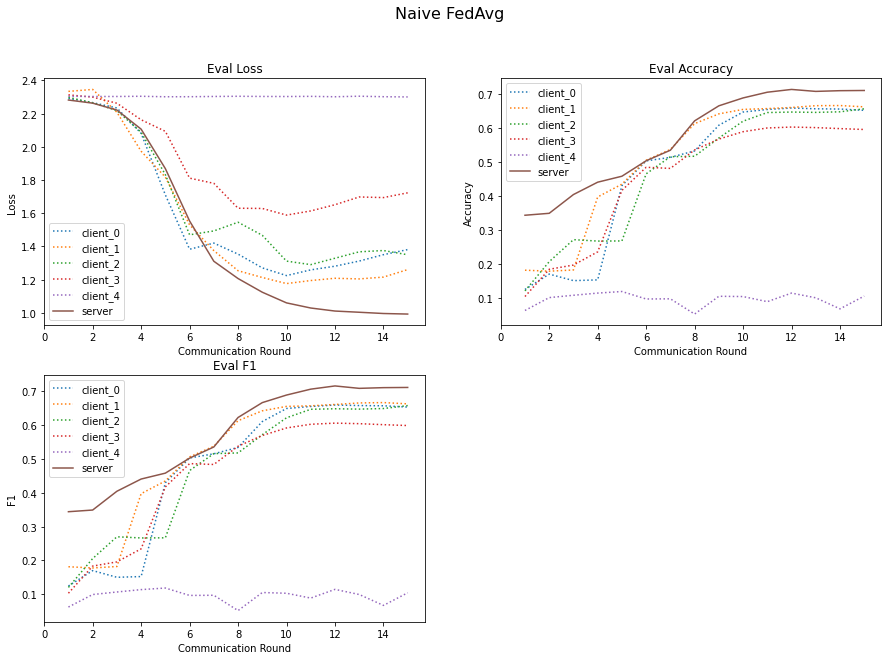

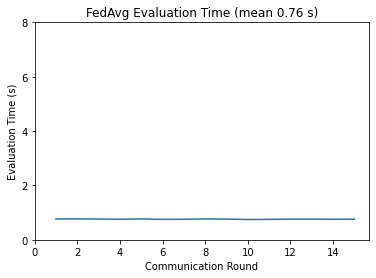

In [ ]:
# Plot evaluation metric figures
figure = plt.figure(figsize=(15, 10))

# Plot Training Loss
figure.add_subplot(2, 2, 1)
for name, ts in fedavg_loss.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# Plot Training Accuracy
figure.add_subplot(2, 2, 2)
for name, ts in fedavg_acc.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Eval Accuracy')

# Plot Training F1
figure.add_subplot(2, 2, 3)
for name, ts in fedavg_f1.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('F1')
plt.legend()
plt.title('Eval F1')

figure.suptitle('Naive FedAvg', fontsize=16)
plt.show()

# Plot Evaluation Time
total_time = sum(fedavg_time)
plt.plot(range(1,len(fedavg_time)+1), fedavg_time)
plt.xticks(np.arange(0, len(fedavg_time)+1, 2))
plt.yticks(np.arange(0, 10, 2))
plt.xlabel('Communication Round')
plt.ylabel('Evaluation Time (s)')
plt.title(f'FedAvg Evaluation Time (mean {total_time/len(fedavg_time):.2f} s)')
plt.show()

## Train a FedAvg-Shapley model

In [ ]:
# Initalize server and clients
server = initServer(model_path,'ShapleyValue',test_dataloader)
clients = initClients(NUM_NORMAL_CLIENTS,NUM_FREERIDER_CLIENTS,NUM_ADVERSARIAL_CLIENTS,server,train_dataloaders)

# Train and evaluate
sv_loss, sv_acc, sv_f1, sv_time, sv_best_coalitions, sv  = trainFedAvgShapleyModel(COMM_ROUNDS, shapley_filter=SHAPLEY_FILTER, coalition_limit=COALITION_LIMIT)

Initializing server model...
MediumMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
) 

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

"server" model saved as "./models/ShapleyValue/server/server_model.pt".

Initializing clients...
Client Name / Behaviour: [('client_0', 'NORMAL'), ('client_1', 'NORMAL'), ('client_2', 'NORMAL'), ('client_3', 'NORMAL'), ('client_4', 'ADVERSARIAL')] 


	ROUND 1
Training client_0 over 10 epochs...
client_0 (NORMAL) Test Acc: 0.097400, Loss: 2.283710, F1: 0.097013
Training client_1 over 10 epochs...
client_1 (NORMAL) Test Acc: 0.156100, Loss: 2.334545, F1: 0

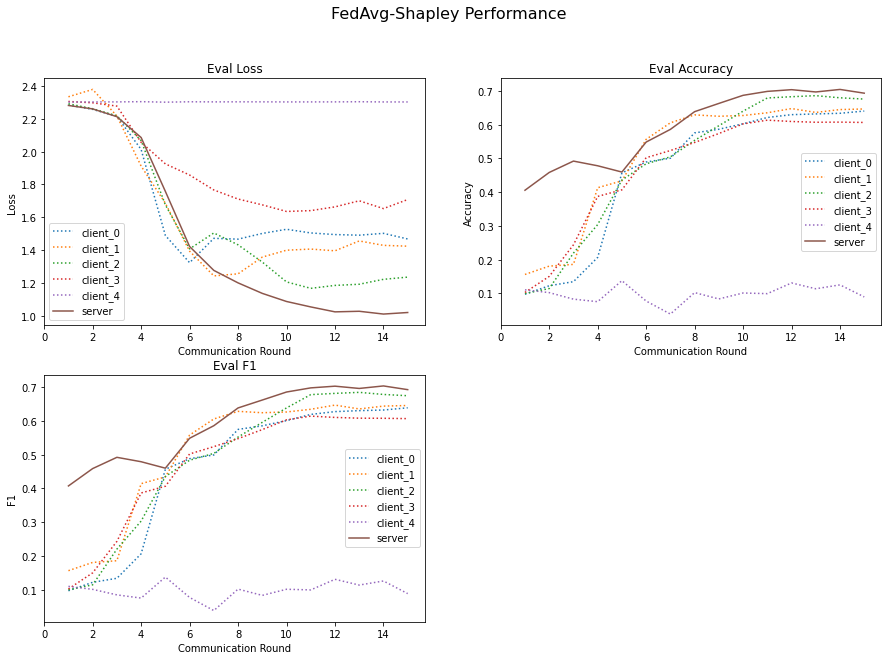


Total Shapley Value Payout: 2.355207


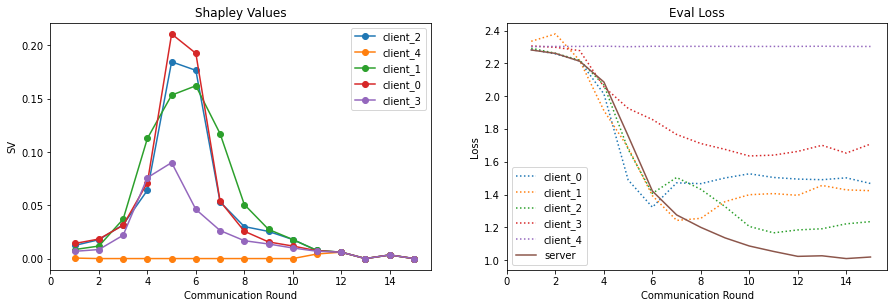

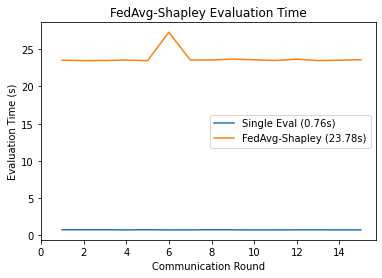

In [ ]:
# Plot evaluation metric figures
figure = plt.figure(figsize=(15, 10))

# Plot Training Loss
figure.add_subplot(2, 2, 1)
for name, ts in sv_loss.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# Plot Training Accuracy
figure.add_subplot(2, 2, 2)
for name, ts in sv_acc.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Eval Accuracy')

# Plot Training F1
figure.add_subplot(2, 2, 3)
for name, ts in sv_f1.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('F1')
plt.legend()
plt.title('Eval F1')
figure.suptitle('FedAvg-Shapley Performance', fontsize=16)
plt.show()

print()

# Plot Shapley Value figures
figure = plt.figure(figsize=(15, 10))

# Plot Shapley Values
figure.add_subplot(2, 2, 1)
sv_total = 0
for name, ts in sv.items():
    sv_total += sum(ts)
    plt.plot(range(1,len(ts)+1), ts, 'o-', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('SV')
plt.legend()
plt.title('Shapley Values')

print(f'Total Shapley Value Payout: {sv_total:>8f}')

# Plot Best Coalition Sizes
''' figure.add_subplot(2, 2, 2)
name2int = [len(name.split('-')) if not name == 'server' else 0 for name in sv_best_coalitions]
plt.plot(range(1,len(name2int)+1), [len(clients) for name in name2int], ':', label='Number of Clients')
plt.plot(range(1,len(name2int)+1), name2int, 'o-', label='Best Coalition Size')
plt.xticks(np.arange(0, len(name2int)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Best Coalition Size')
plt.legend()
plt.title('Best Coalition Size per Communication Round') '''
name2int = [len(name.split('-')) if not name == 'server' else 0 for name in sv_best_coalitions]

# Plot Training Loss
figure.add_subplot(2, 2, 2)
for name, ts in sv_loss.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# figure.suptitle('FedAvg-Shapley SV Evaluations', fontsize=16)
plt.show()

print()

# Plot Evaluation Time
plt.plot(range(1,len(fedavg_time)+1), fedavg_time, label=f'Single Eval ({sum(fedavg_time)/len(fedavg_time):.2f}s)')
plt.plot(range(1,len(sv_time)+1), sv_time, label=f'FedAvg-Shapley ({sum(sv_time)/len(sv_time):.2f}s)')
plt.xticks(np.arange(0, len(sv_time)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Evaluation Time (s)')
plt.legend()
plt.title(f'FedAvg-Shapley Evaluation Time')

plt.show()

# Miscellaneous Code Samples



In [ ]:
# Initalize server and clients
server = initServer(model_path,'ShapleyValue-SF',test_dataloader)
clients = initClients(NUM_NORMAL_CLIENTS,NUM_FREERIDER_CLIENTS,NUM_ADVERSARIAL_CLIENTS,server,train_dataloaders)

# Train and evaluate
sv_loss2, sv_acc2, sv_f12, sv_time2, sv_best_coalitions2, sv2  = trainFedAvgShapleyModel(COMM_ROUNDS, shapley_filter=True, coalition_limit=COALITION_LIMIT)

Initializing server model...
MediumMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
) 

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

"server" model saved as "./models/ShapleyValue-SF/server/server_model.pt".

Initializing clients...
Client Name / Behaviour: [('client_0', 'NORMAL'), ('client_1', 'NORMAL'), ('client_2', 'NORMAL'), ('client_3', 'NORMAL'), ('client_4', 'ADVERSARIAL')] 


	ROUND 1
Training client_0 over 10 epochs...
client_0 (NORMAL) Test Acc: 0.097400, Loss: 2.287019, F1: 0.097013
Training client_1 over 10 epochs...
client_1 (NORMAL) Test Acc: 0.181600, Loss: 2.313729, F1

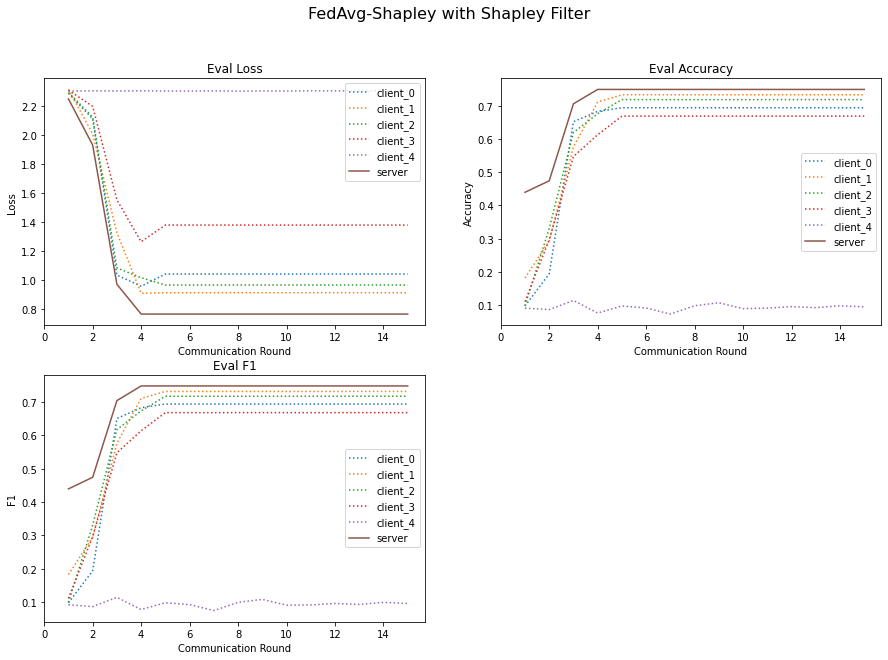


Total Shapley Value Payout: 1.418848


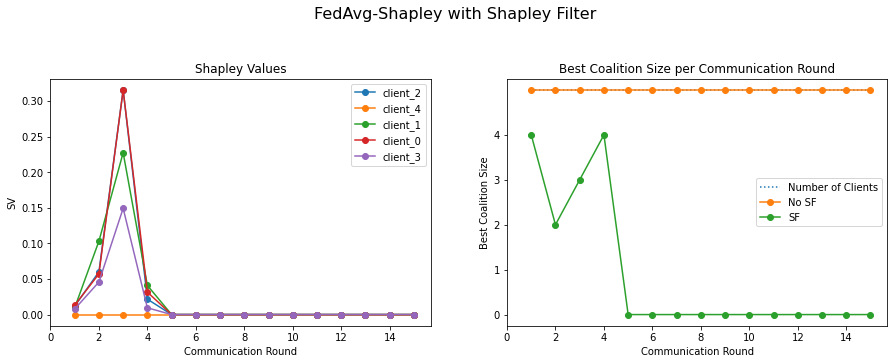

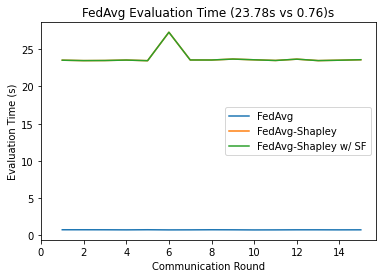

In [ ]:
# Plot evaluation metric figures
figure = plt.figure(figsize=(15, 10))

# Plot Training Loss
figure.add_subplot(2, 2, 1)
for name, ts in sv_loss2.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# Plot Training Accuracy
figure.add_subplot(2, 2, 2)
for name, ts in sv_acc2.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Eval Accuracy')

# Plot Training F1
figure.add_subplot(2, 2, 3)
for name, ts in sv_f12.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('F1')
plt.legend()
plt.title('Eval F1')

figure.suptitle('FedAvg-Shapley with Shapley Filter', fontsize=16)
plt.show()

print()

# Plot Shapley Value figures
figure = plt.figure(figsize=(15, 10))

# Plot Shapley Values
figure.add_subplot(2, 2, 1)
sv_total2 = 0
for name, ts in sv2.items():
    sv_total2 += sum(ts)
    plt.plot(range(1,len(ts)+1), ts, 'o-', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('SV')
plt.legend()
plt.title('Shapley Values')

print(f'Total Shapley Value Payout: {sv_total2:>8f}')

# Plot Best Coalition Sizes
figure.add_subplot(2, 2, 2)
name2int2 = [len(name.split('-')) if not name == 'server' else 0 for name in sv_best_coalitions2]
plt.plot(range(1,len(name2int)+1), [len(clients) for name in name2int], ':', label='Number of Clients')
plt.plot(range(1,len(name2int)+1), name2int, 'o-', label='No SF')
plt.plot(range(1,len(name2int)+1), name2int2, 'o-', label='SF')
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.yticks(np.arange(0, max(name2int2)+1, 1))
plt.xlabel('Communication Round')
plt.ylabel('Best Coalition Size')
plt.legend()
plt.title('Best Coalition Size per Communication Round')

figure.suptitle('FedAvg-Shapley with Shapley Filter', fontsize=16)
plt.show()

print()

# Plot Evaluation Time
plt.plot(range(1,len(fedavg_time)+1), fedavg_time, label='FedAvg')
plt.plot(range(1,len(sv_time)+1), sv_time, label='FedAvg-Shapley')
plt.plot(range(1,len(sv_time2)+1), sv_time, label='FedAvg-Shapley w/ SF')
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Evaluation Time (s)')
plt.legend()
plt.title(f'FedAvg Evaluation Time ({sum(sv_time)/len(sv_time):.2f}s vs {sum(fedavg_time)/len(fedavg_time):.2f})s')

plt.show()

In [ ]:
# Initalize server and clients
server = initServer(model_path,'ShapleyValue-CL3',test_dataloader)
clients = initClients(NUM_NORMAL_CLIENTS,NUM_FREERIDER_CLIENTS,NUM_ADVERSARIAL_CLIENTS,server,train_dataloaders)

# Train and evaluate
sv_loss3, sv_acc3, sv_f13, sv_time3, sv_best_coalitions3, sv3  = trainFedAvgShapleyModel(COMM_ROUNDS, shapley_filter=True, coalition_limit=3)

Initializing server model...
MediumMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
) 

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

"server" model saved as "./models/ShapleyValue-CL3/server/server_model.pt".

Initializing clients...
Client Name / Behaviour: [('client_0', 'NORMAL'), ('client_1', 'NORMAL'), ('client_2', 'NORMAL'), ('client_3', 'NORMAL'), ('client_4', 'ADVERSARIAL')] 


	ROUND 1
Training client_0 over 10 epochs...
client_0 (NORMAL) Test Acc: 0.121000, Loss: 2.291481, F1: 0.121044
Training client_1 over 10 epochs...
client_1 (NORMAL) Test Acc: 0.182500, Loss: 2.327122, F

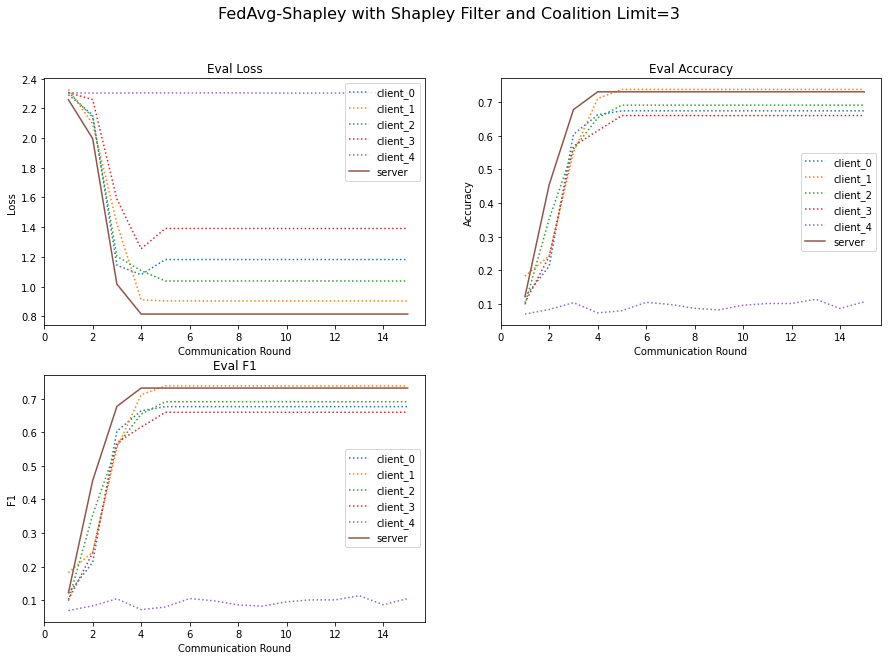


Total Shapley Value Payout: 1.673110


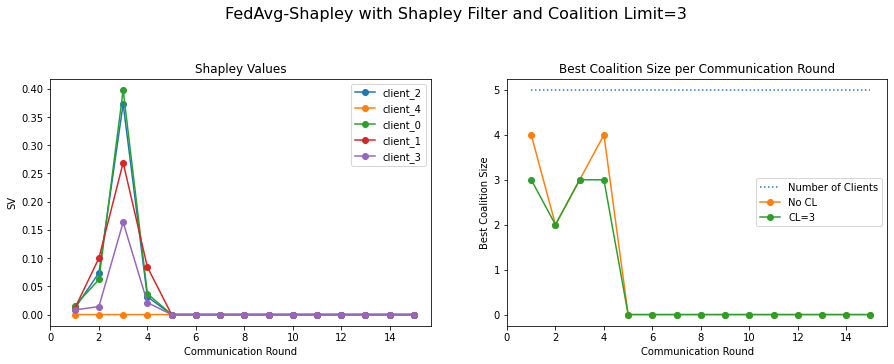

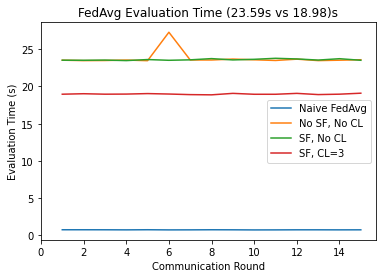

In [ ]:
# Plot evaluation metric figures
figure = plt.figure(figsize=(15, 10))

# Plot Training Loss
figure.add_subplot(2, 2, 1)
for name, ts in sv_loss3.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# Plot Training Accuracy
figure.add_subplot(2, 2, 2)
for name, ts in sv_acc3.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Eval Accuracy')

# Plot Training F1
figure.add_subplot(2, 2, 3)
for name, ts in sv_f13.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('F1')
plt.legend()
plt.title('Eval F1')

figure.suptitle('FedAvg-Shapley with Shapley Filter and Coalition Limit=3', fontsize=16)
plt.show()

print()

# Plot Shapley Value figures
figure = plt.figure(figsize=(15, 10))

# Plot Shapley Values
figure.add_subplot(2, 2, 1)
sv_total3 = 0
for name, ts in sv3.items():
    sv_total3 += sum(ts)
    plt.plot(range(1,len(ts)+1), ts, 'o-', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('SV')
plt.legend()
plt.title('Shapley Values')

print(f'Total Shapley Value Payout: {sv_total3:>8f}')

# Plot Best Coalition Sizes
figure.add_subplot(2, 2, 2)
name2int3 = [len(name.split('-')) if not name == 'server' else 0 for name in sv_best_coalitions3]
plt.plot(range(1,len(name2int)+1), [len(clients) for name in name2int], ':', label='Number of Clients')
plt.plot(range(1,len(name2int)+1), name2int2, 'o-', label='No CL')
plt.plot(range(1,len(name2int)+1), name2int3, 'o-', label='CL=3')
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.yticks(np.arange(0, len(clients)+1, 1))
plt.xlabel('Communication Round')
plt.ylabel('Best Coalition Size')
plt.legend()
plt.title('Best Coalition Size per Communication Round')

figure.suptitle('FedAvg-Shapley with Shapley Filter and Coalition Limit=3', fontsize=16)
plt.show()

print()

# Plot Evaluation Time
plt.plot(range(1,len(fedavg_time)+1), fedavg_time, label='Naive FedAvg')
plt.plot(range(1,len(sv_time)+1), sv_time, label='No SF, No CL')
plt.plot(range(1,len(sv_time2)+1), sv_time2, label='SF, No CL')
plt.plot(range(1,len(sv_time3)+1), sv_time3, label='SF, CL=3')
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Evaluation Time (s)')
plt.legend()
plt.title(f'FedAvg Evaluation Time ({sum(sv_time2)/len(sv_time2):.2f}s vs {sum(sv_time3)/len(sv_time3):.2f})s')

plt.show()

In [ ]:
# Initalize server and clients
server = initServer(model_path,'ShapleyValue-CL2',test_dataloader)
clients = initClients(NUM_NORMAL_CLIENTS,NUM_FREERIDER_CLIENTS,NUM_ADVERSARIAL_CLIENTS,server,train_dataloaders)

# Train and evaluate
sv_loss4, sv_acc4, sv_f14, sv_time4, sv_best_coalitions4, sv4  = trainFedAvgShapleyModel(COMM_ROUNDS, shapley_filter=True, coalition_limit=2)

Initializing server model...
MediumMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
) 

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

"server" model saved as "./models/ShapleyValue-CL2/server/server_model.pt".

Initializing clients...
Client Name / Behaviour: [('client_0', 'NORMAL'), ('client_1', 'NORMAL'), ('client_2', 'NORMAL'), ('client_3', 'NORMAL'), ('client_4', 'ADVERSARIAL')] 


	ROUND 1
Training client_0 over 10 epochs...
client_0 (NORMAL) Test Acc: 0.097400, Loss: 2.290487, F1: 0.097013
Training client_1 over 10 epochs...
client_1 (NORMAL) Test Acc: 0.144700, Loss: 2.319637, F

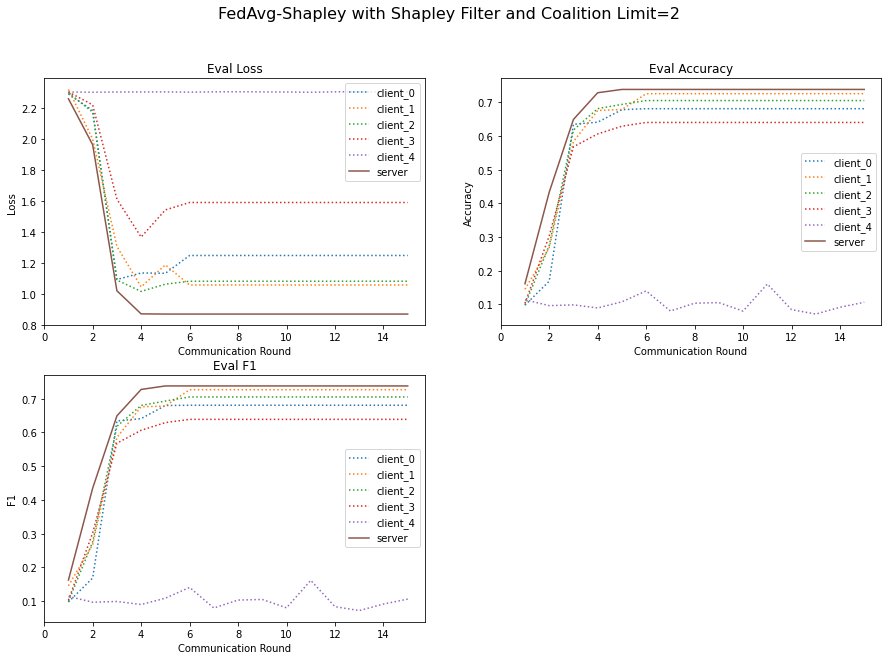

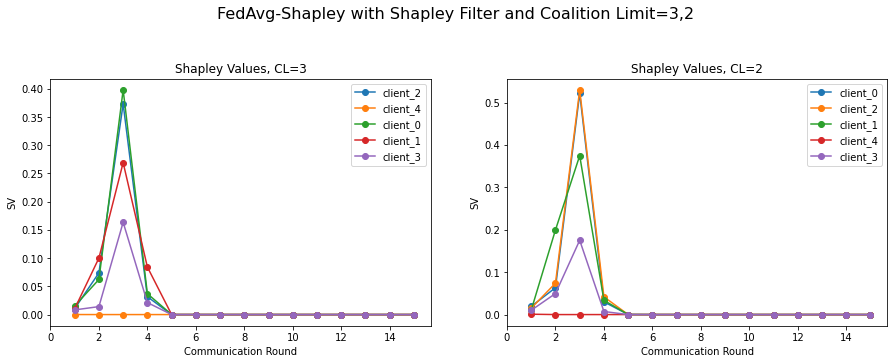

Total Shapley Value Payout: 2.157203


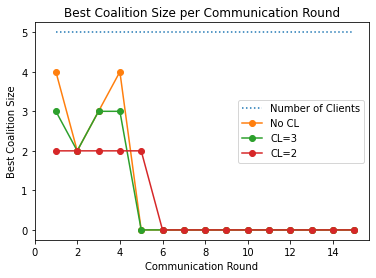

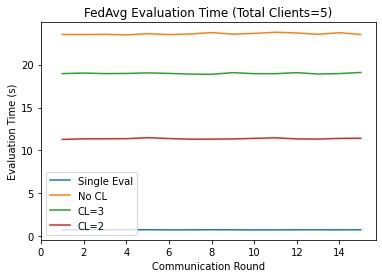

In [ ]:
# Plot evaluation metric figures
figure = plt.figure(figsize=(15, 10))

# Plot Training Loss
figure.add_subplot(2, 2, 1)
for name, ts in sv_loss4.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Eval Loss')

# Plot Training Accuracy
figure.add_subplot(2, 2, 2)
for name, ts in sv_acc4.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Eval Accuracy')

# Plot Training F1
figure.add_subplot(2, 2, 3)
for name, ts in sv_f14.items():
    if name == 'server':
        plt.plot(range(1,len(ts)+1), ts, label=name)
    else:
        plt.plot(range(1,len(ts)+1), ts, ':', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('F1')
plt.legend()
plt.title('Eval F1')

figure.suptitle('FedAvg-Shapley with Shapley Filter and Coalition Limit=2', fontsize=16)
plt.show()

print()

# Plot Shapley Value figures
figure = plt.figure(figsize=(15, 10))

# Plot Shapley Values
figure.add_subplot(2, 2, 1)
for name, ts in sv3.items():
    plt.plot(range(1,len(ts)+1), ts, 'o-', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('SV')
plt.legend()
plt.title('Shapley Values, CL=3')

figure.add_subplot(2, 2, 2)
sv_total4 = 0
for name, ts in sv4.items():
    sv_total4 += sum(ts)
    plt.plot(range(1,len(ts)+1), ts, 'o-', label=name)
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('SV')
plt.legend()
plt.title('Shapley Values, CL=2')
figure.suptitle('FedAvg-Shapley with Shapley Filter and Coalition Limit=3,2', fontsize=16)

plt.show()

print(f'Total Shapley Value Payout: {sv_total4:>8f}')

# Plot Best Coalition Sizes
figure.add_subplot(2, 2, 3)
name2int4 = [len(name.split('-')) if not name == 'server' else 0 for name in sv_best_coalitions4]
plt.plot(range(1,len(name2int)+1), [len(clients) for name in name2int], ':', label='Number of Clients')
plt.plot(range(1,len(name2int)+1), name2int2, 'o-', label='No CL')
plt.plot(range(1,len(name2int)+1), name2int3, 'o-', label='CL=3')
plt.plot(range(1,len(name2int)+1), name2int4, 'o-', label='CL=2')
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.yticks(np.arange(0, len(clients)+1, 1))
plt.xlabel('Communication Round')
plt.ylabel('Best Coalition Size')
plt.legend()
plt.title('Best Coalition Size per Communication Round')

plt.show()

print()

# Plot Evaluation Time
plt.plot(range(1,len(fedavg_time)+1), fedavg_time, label='Single Eval')
plt.plot(range(1,len(sv_time2)+1), sv_time2, label='No CL')
plt.plot(range(1,len(sv_time3)+1), sv_time3, label='CL=3')
plt.plot(range(1,len(sv_time4)+1), sv_time4, label='CL=2')
plt.xticks(np.arange(0, len(ts)+1, 2))
plt.xlabel('Communication Round')
plt.ylabel('Evaluation Time (s)')
plt.legend()
plt.title(f'FedAvg Evaluation Time (Total Clients={len(clients)})')

plt.show()